In [1]:
LOGIC = ["Negation", "Double negation", "Intervals/Numbers", "Conjunction", "Disjunction",
          "Conditionals", "Universal", "Existential", "Temporal", "Upward monotone",
          "Downward monotone", "Non-monotone",
        ]
LEXSEM = ["Lexical entailment", "Morphological negation", "Factivity", "Symmetry/Collectivity",
            "Redundancy", "Named entities", "Quantifiers",
         ]
PAS = ["Core args", "Prepositional phrases", "Ellipsis/Implicits", "Anaphora/Coreference",
        "Active/Passive", "Nominalization", "Genitives/Partitives", "Datives", "Relative clauses",
        "Coordination scope", "Intersectivity", "Restrictivity",
      ]
KNOWLEDGE = ["Common sense", "World knowledge"]

In [2]:
from allennlp.predictors.predictor import Predictor
import allennlp_models.structured_prediction

ie_extractor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz")

In [3]:
import os
from Udep2Mono.util import *
from Udep2Mono.dependency_parse import dependency_parse
from Udep2Mono.binarization import BinaryDependencyTree, Binarizer

from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display

def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    os.system('rm -rf ../data/tree.png')
    os.system('rm -rf ../data/tree.ps')
    cf.print_to_file('../data/tree.ps')
    cf.destroy()
    os.system('magick convert ../data/tree.ps ../data/tree.png')
    display(Image(filename='../data/tree.png'))
    
binarizer = Binarizer()

INFO:stanza:Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | gum       |
| pos       | gum       |
| lemma     | gum       |
| depparse  | gum       |
| sentiment | sstplus   |
| ner       | ontonotes |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


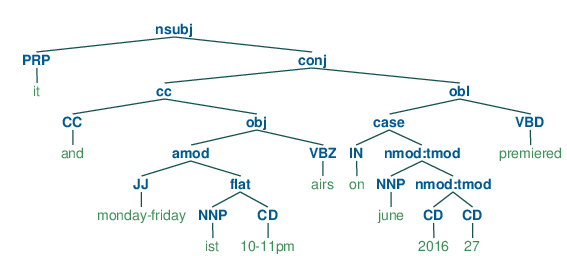

In [11]:
parsed, replaced = dependency_parse("It premiered on 27 June, 2016 and airs Monday-Friday 10-11pm IST", "stanza")
tree, postag, words = parsed

binarizer.parse_table = tree
binarizer.postag = postag
binarizer.words = words
binaryDepdency, relation = binarizer.binarization()

sexpression = btreeToList(binaryDepdency, len(words), replaced, 0)[0]
sexpression = str(sexpression).replace(',', ' ').replace("'", '')
sexpression = sexpression.replace('[', '(').replace(']', ')')
btreeViz = Tree.fromstring(sexpression)
jupyter_draw_nltk_tree(btreeViz) 

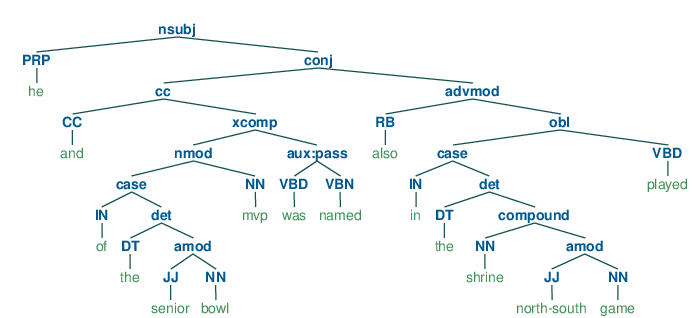

In [5]:
parsed, replaced = dependency_parse("He also played in the North-South Shrine Game and was named MVP of the Senior Bowl", "stanza")
tree, postag, words = parsed

binarizer.parse_table = tree
binarizer.postag = postag
binarizer.words = words
binaryDepdency, relation = binarizer.binarization()

sexpression = btreeToList(binaryDepdency, len(words), replaced, 0)[0]
sexpression = str(sexpression).replace(',', ' ').replace("'", '')
sexpression = sexpression.replace('[', '(').replace(']', ')')
btreeViz = Tree.fromstring(sexpression)
jupyter_draw_nltk_tree(btreeViz) 

In [16]:
from pattern.en import conjugate, lemma, lexeme, PAST, PRESENT, PARTICIPLE

def pass2act(sentence, postag):
    ie_pred = ie_extractor.predict(sentence)['verbs']
    
    def fix_info(desc):
        out = desc.replace("ARG0: ", "")
        out = out.replace("ARG1: ", "")
        out = out.replace("V: ", "")
        out = out.replace("[", "")
        out = out.replace("]", ",")
        out = out.split(",")
        return out
    
    def get_aux(noun, verb):
        aux = "is"
        if postag[noun][1] == "NN":
            if postag[verb][1] == "VBD":
                aux = "was"
            elif postag[verb][1] == "VBS":
                aux = "will be"
            else:
                aux = "is"
        elif postag[noun][1] == "NNS":
            if postag[verb][1] == "VBD":
                aux = "were"
            elif postag[verb][1] == "VBS":
                aux = "will be"
            else:
                aux = "are"
        return aux + " "
        
    
    for verb in ie_pred:
        predicate = fix_info(verb['description'])
        print(predicate)
        passive = [0,0,0]
        passive[0] = predicate[2].strip()
        passive[2] = "by " + predicate[0].strip()
        passive_verb = conjugate(predicate[1].strip(), (PAST,PARTICIPLE), 1)
        parsed, _ = dependency_parse(passive[0], "stanza")
        tree, _, words = parsed 
        noun = ""
        for node in tree:
            if node[0] == "root":
                noun = words[node[1]][0]
                print(noun)
        aux = get_aux(noun, predicate[1].strip())
        passive[1] = aux + passive_verb
        print(passive)

In [17]:
parsed, replaced = dependency_parse("John took some apples", "stanza")
tree, postag, words = parsed
pass2act("John took some apples", postag)

['John', ' took', ' some apples', '']
apples
['some apples', 'were taken', 'by John']
